In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn import metrics
from enum import Enum, auto
import joblib
from pathlib import Path



In [2]:
class MyEnum(Enum):
    ITALIAN = auto()
    MDVR = auto()

selected_option = MyEnum.ITALIAN

In [3]:
final_results_df = pd.DataFrame(columns=('accuracy', 'precision', 'recall', 'f1-score'))

In [4]:
#save values to final table



def saveMetricsFinalDf(name, y_test, y_predict):
    final_accuracy = round(classification_report(y_test, y_predict, labels=[1, 0], output_dict=True)['accuracy'],2)
    final_precision = round(classification_report(y_test, y_predict, labels=[1, 0], output_dict=True)['weighted avg']['precision'],2)
    final_recall = round(classification_report(y_test, y_predict, labels=[1, 0], output_dict=True)['weighted avg']['recall'],2)
    final_f1score = round(classification_report(y_test, y_predict, labels=[1, 0], output_dict=True)['weighted avg']['f1-score'],2)
    final_results_df.loc[name] = [final_accuracy, final_precision, final_recall, final_f1score]

def saveModel(model, model_name):
    if selected_option == MyEnum.ITALIAN:
        dataset = "italian"
    elif selected_option == MyEnum.MDVR:
        dataset = "mdvr"
    # Save the trained model to a file
    
    dir = os.path.join("../data/models", dataset)
    Path(dir).mkdir(parents=True, exist_ok=True)

    model_filename = os.path.join(dir , model_name + '.joblib')
    joblib.dump(model, model_filename)



# Model Building

In [5]:


if selected_option == MyEnum.ITALIAN:
    features_df = pd.read_csv("../data/tables/italian_features.csv")
    reduced_features_df = pd.read_csv("../data/tables/italian_reduced_features.csv")
elif selected_option == MyEnum.MDVR:
    features_df = pd.read_csv("../data/tables/mdvr_features.csv")
    reduced_features_df = pd.read_csv("../data/tables/mdvr_reduced_features.csv")
else:
    print("Unknown option")



In [6]:
features_df

,meanF0,stdevF0,hnr,localJitter,localabsoluteJitter,rapJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,...,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,PD
0,129.307948,2.064876,23.959287,0.004173,0.000032,0.002187,0.002334,0.006560,0.024436,0.224043,...,-55.282018,38.665621,28.515129,34.121017,-40.358730,29.238105,-24.270815,10.154970,-34.798571,1.0
1,122.038081,5.155957,27.957755,0.004510,0.000037,0.002313,0.002498,0.006938,0.014446,0.175230,...,18.800874,24.925375,-99.857594,-37.270614,14.163572,18.289177,-10.002558,-12.910693,10.102795,1.0
2,138.828247,2.136906,33.309475,0.002323,0.000017,0.001113,0.001179,0.003339,0.007289,0.068204,...,30.427561,39.399160,-32.548469,-65.738446,-77.103148,7.728334,-9.946325,-15.429777,-5.522128,1.0
3,213.347835,3.371491,26.434427,0.003564,0.000016,0.002018,0.001938,0.006054,0.012845,0.112993,...,30.427561,-30.248495,-93.353060,-39.482232,-17.346727,-28.619096,-32.626611,-26.639631,-31.803623,1.0
4,146.076736,16.504125,30.583621,0.003027,0.000021,0.001518,0.001504,0.004555,0.011083,0.122816,...,-0.390715,39.399160,-27.637685,-18.008237,-75.936431,-7.159779,19.169686,16.472681,6.557673,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,120.238273,15.841945,31.049953,0.002637,0.000022,0.001333,0.001443,0.004000,0.016649,0.184037,...,-82.443054,-80.722589,-47.682495,-24.159954,-28.355728,8.521285,1.230935,12.537409,-2.654274,0.0
489,125.702970,3.419908,14.176360,0.006556,0.000052,0.003642,0.003866,0.010925,0.061772,0.595184,...,-78.149194,30.988700,24.493318,-20.969052,-23.542736,-1.080957,-16.940854,-6.063577,3.062718,0.0
490,132.869272,19.792501,12.890455,0.007489,0.000055,0.003827,0.004149,0.011480,0.061772,0.595184,...,-92.426071,-16.278222,24.494387,-1.847811,-56.114239,29.238105,-18.890684,-7.737241,-17.210579,0.0
491,213.347835,5.931401,14.642913,0.007489,0.000055,0.003827,0.004233,0.011480,0.061772,0.595184,...,-17.330426,-34.816876,-25.159511,-11.765553,10.364775,-18.593119,-27.932900,-38.736094,-18.634262,0.0


In [7]:

reduced_features_df

,meanF0,stdevF0,hnr,localJitter,localabsoluteJitter,rapJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,...,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12
0,129.307948,2.064876,23.959287,0.004173,0.000032,0.002187,0.002334,0.006560,0.024436,0.224043,...,-14.005976,-55.282018,38.665621,28.515129,34.121017,-40.358730,29.238105,-24.270815,10.154970,-34.798571
1,122.038081,5.155957,27.957755,0.004510,0.000037,0.002313,0.002498,0.006938,0.014446,0.175230,...,136.738420,18.800874,24.925375,-99.857594,-37.270614,14.163572,18.289177,-10.002558,-12.910693,10.102795
2,138.828247,2.136906,33.309475,0.002323,0.000017,0.001113,0.001179,0.003339,0.007289,0.068204,...,152.050641,30.427561,39.399160,-32.548469,-65.738446,-77.103148,7.728334,-9.946325,-15.429777,-5.522128
3,213.347835,3.371491,26.434427,0.003564,0.000016,0.002018,0.001938,0.006054,0.012845,0.112993,...,152.050641,30.427561,-30.248495,-93.353060,-39.482232,-17.346727,-28.619096,-32.626611,-26.639631,-31.803623
4,146.076736,16.504125,30.583621,0.003027,0.000021,0.001518,0.001504,0.004555,0.011083,0.122816,...,131.076230,-0.390715,39.399160,-27.637685,-18.008237,-75.936431,-7.159779,19.169686,16.472681,6.557673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,120.238273,15.841945,31.049953,0.002637,0.000022,0.001333,0.001443,0.004000,0.016649,0.184037,...,28.398967,-82.443054,-80.722589,-47.682495,-24.159954,-28.355728,8.521285,1.230935,12.537409,-2.654274
489,125.702970,3.419908,14.176360,0.006556,0.000052,0.003642,0.003866,0.010925,0.061772,0.595184,...,-93.156153,-78.149194,30.988700,24.493318,-20.969052,-23.542736,-1.080957,-16.940854,-6.063577,3.062718
490,132.869272,19.792501,12.890455,0.007489,0.000055,0.003827,0.004149,0.011480,0.061772,0.595184,...,-43.393458,-92.426071,-16.278222,24.494387,-1.847811,-56.114239,29.238105,-18.890684,-7.737241,-17.210579
491,213.347835,5.931401,14.642913,0.007489,0.000055,0.003827,0.004233,0.011480,0.061772,0.595184,...,-3.331834,-17.330426,-34.816876,-25.159511,-11.765553,10.364775,-18.593119,-27.932900,-38.736094,-18.634262


In [8]:
# lets build our classification model
# independent variables
X = reduced_features_df
# X=pd.DataFrame(X_stand1)
# the dependent variable
y = features_df['PD']



In [9]:

if selected_option == MyEnum.ITALIAN:
    dataset = "italian"
elif selected_option == MyEnum.MDVR:
    dataset = "mdvr"
# Save the trained model to a file

dir = "../data/models/" + dataset + "/"
features_names_path = dir + 'features_names' + '.joblib'


In [10]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.30,random_state=1)

In [11]:
print("{0:0.2f}% data is in training set".format((len(X_train)/len(reduced_features_df.index)) * 100))
print("{0:0.2f}% data is in test set".format((len(X_test)/len(reduced_features_df.index)) * 100))

69.98% data is in training set
30.02% data is in test set


In [12]:
y_train_yPD=y_train[y_train==1].count()
y_train_nPD=y_train[y_train==0].count()
y_test_yPD=y_test[y_test==1].count()
y_test_nPD=y_test[y_test==0].count()

print("In the original dataset people who had parkinson Dieases    : {0} ({1:0.2f}%)".format(len(reduced_features_df.loc[features_df['PD'] == 1]), (len(reduced_features_df.loc[features_df['PD'] == 1])/len(reduced_features_df.index)) * 100))
print("In the original dataset people who didnot have Parkinson Disease   : {0} ({1:0.2f}%)".format(len(reduced_features_df.loc[features_df['PD'] == 0]), (len(reduced_features_df.loc[features_df['PD'] == 0])/len(reduced_features_df.index)) * 100))
print("")
print("In the training dataset people who who had parkinson Dieases    : {0} ({1:0.2f}%)".format(y_train_yPD, (y_train_yPD/len(y_train))*100))
print("In the training dataset people who didnot have Parkinson Disease    : {0} ({1:0.2f}%)".format(y_train_nPD, (y_train_nPD/len(y_train))*100))
print("")
print("In the test dataset people who who had parkinson Dieases    : {0} ({1:0.2f}%)".format(y_test_yPD, (y_test_yPD/len(y_test))*100))
print("In the test dataset people who didnot have Parkinson Disease    : {0} ({1:0.2f}%)".format(y_test_nPD, (y_test_nPD/len(y_test))*100))

In the original dataset people who had parkinson Dieases    : 274 (55.58%)
In the original dataset people who didnot have Parkinson Disease   : 219 (44.42%)

In the training dataset people who who had parkinson Dieases    : 199 (57.68%)
In the training dataset people who didnot have Parkinson Disease    : 146 (42.32%)

In the test dataset people who who had parkinson Dieases    : 75 (50.68%)
In the test dataset people who didnot have Parkinson Disease    : 73 (49.32%)


scScales impact

Gradient descent based algorithms like Linear Regression, Logistics Regression
Distance based algorithms like KNN, K-means and SVM
Scales dont impact:

Tree based algorithms like Decision trees

In [13]:
# Scale


sc = MinMaxScaler()


print(X_train.loc[195])

X_train = pd.DataFrame(sc.fit_transform(X_train.values), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(sc.transform(X_test.values), columns=X_test.columns, index=X_test.index)



print(X_train.loc[195])

X_test.to_csv('/Users/tomas/Desktop/X_test_scaled.csv', index=False)



if not os.path.exists(dir):
    os.makedirs(dir, exist_ok=True)


scaler_path = dir + 'scaler' + '.save'
features_names_path = dir + 'features_names' + '.joblib'

joblib.dump(sc, scaler_path)
joblib.dump(X_train.columns, features_names_path)

pd.DataFrame(X_train)

meanF0                 193.867877
stdevF0                  3.139372
hnr                     27.402803
localJitter              0.003267
localabsoluteJitter      0.000017
rapJitter                0.001710
ppq5Jitter               0.001723
ddpJitter                0.005129
localShimmer             0.017574
localdbShimmer           0.158803
apq3Shimmer              0.007409
aqpq5Shimmer             0.008629
apq11Shimmer             0.014437
ddaShimmer               0.022228
mfcc0                  670.738077
mfcc1                  240.175291
mfcc2                   -8.865278
mfcc3                  -20.649968
mfcc4                  -36.895140
mfcc5                   30.855564
mfcc6                   17.685932
mfcc7                  -50.045151
mfcc8                    7.354735
mfcc9                    3.415032
mfcc10                 -31.482636
mfcc11                 -18.788378
mfcc12                 -22.624584
Name: 195, dtype: float64
meanF0                 0.848922
stdevF0                0

,meanF0,stdevF0,hnr,localJitter,localabsoluteJitter,rapJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,...,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12
294,0.545668,0.126969,0.981211,0.175208,0.194004,0.160576,0.159401,0.160576,0.245514,0.278219,...,0.556800,0.397780,0.500000,0.839644,0.609536,0.561801,0.464881,0.660592,0.953588,0.613152
39,1.000000,0.099499,0.894791,1.000000,0.676844,1.000000,1.000000,1.000000,0.367698,0.325691,...,0.591120,0.193162,0.734071,0.586352,0.545593,0.486709,0.120678,1.000000,0.236060,0.868632
353,0.504173,0.054303,0.602866,0.226037,0.247956,0.230121,0.223387,0.230121,0.428705,0.427510,...,0.613669,0.718267,0.530651,0.453298,0.952743,0.851010,0.933840,0.283899,0.705058,0.650448
414,0.166869,0.106044,0.572293,0.938512,1.000000,1.000000,0.856387,1.000000,0.520195,0.511319,...,0.730026,0.420808,0.423650,0.552306,0.553969,0.514112,0.757884,0.611064,0.786761,1.000000
385,1.000000,0.228084,0.844451,0.056925,0.033994,0.058943,0.029716,0.058943,0.285280,0.233558,...,0.298092,0.458454,0.964236,0.693802,0.000000,0.461900,0.527183,1.000000,0.969662,0.249848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,1.000000,0.128106,0.961058,0.524030,0.299538,0.653539,0.357105,0.653539,0.211973,0.195541,...,0.941219,1.000000,1.000000,0.426100,0.185730,0.194882,0.356481,0.525827,0.774273,0.119666
72,1.000000,0.864955,0.976952,0.372180,0.104554,0.204335,0.161477,0.204335,0.203217,0.214992,...,0.462064,0.431010,0.653490,0.498875,0.551712,0.607592,0.521814,0.535585,0.473790,1.000000
396,0.714821,0.070421,1.000000,0.066966,0.079594,0.062251,0.081416,0.062251,0.208837,0.169960,...,0.566662,0.146710,0.373258,0.577340,0.670382,0.868481,0.724356,0.332392,0.469747,0.886486
235,0.534645,0.135744,0.558532,0.951680,0.843946,1.000000,1.000000,1.000000,0.466144,0.426091,...,0.788776,1.000000,0.594849,0.499637,0.916856,0.770723,0.935073,0.297026,0.790576,0.508615


In [14]:
if (pd.DataFrame(X_train).isnull().sum().any()==0):
    print('There are no null values in the training datset')
else:
    print('There are null values in the training datset')

if (pd.DataFrame(X_test).isnull().sum().any()==0):
    print('There are no null values in the test datset')
else:
    print('There are null values in the test datset')

There are no null values in the training datset
There are no null values in the test datset


In [15]:
def predictedVsActualTable(model, X_test, y_test, model_type = None):
    # Predict probabilities on the test data
    y_predict_proba = model.predict_proba(X_test)

    # y_predict_prob is an array where each row contains the probability estimates for each class
    # Assuming you are interested in the probability of the positive class (class 1)
    positive_class_prob = y_predict_proba[:, 1]

    # Create a DataFrame to compare each individual predicted probability to the real value
    comparison_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted_Probability': positive_class_prob,
        'Predicted_Class': model.predict(X_test)
    })
    if model_type == None:
        comparison_df.Name = type(model).__name__
    else:
        comparison_df.Name = model_type.__name__

    # Print or use the DataFrame as needed
    pd.set_option('display.max_rows', 50)
    return comparison_df




def predictedVsActualPlot(comparison_df):

    # Sort the DataFrame by the 'Actual' column
    model_name = comparison_df.Name
    sorted_df = comparison_df.sort_values(by='Actual')

    # Scatter plot of Actual vs Predicted Probability
    plt.figure(figsize=(10, 7))
    plt.scatter(range(len(sorted_df)), sorted_df['Actual'], label='Actual', color='blue', alpha=0.7)
    plt.scatter(range(len(sorted_df)), sorted_df['Predicted_Probability'], label='Predicted Probability', color='red', alpha=0.7)

    # Draw a horizontal line at y=0.5
    plt.axhline(y=0.5, color='green', linestyle='--', label='Threshold (0.5)')

    plt.xlabel('Data Point (Index)')
    plt.ylabel('Values')
    plt.title('Actual vs Predicted Probability ' + model_name)
    plt.legend()
    plt.show()

# Logistic Regression

In [16]:
# Fit the model on train data
model_lr = LogisticRegression(solver="liblinear")
model_lr.fit(X_train,y_train)

# predict on the test data
y_predict_lr = model_lr.predict(X_test)
y_predict_lr

coef_df = pd.DataFrame(model_lr.coef_)
coef_df['intercept'] = model_lr.intercept_
coef_df

model_score_lr = model_lr.score(X_test, y_test)


In [17]:
table_lr = predictedVsActualTable(model_lr, X_test, y_test)
print(table_lr)

     Actual  Predicted_Probability  Predicted_Class
354     0.0               0.012446              0.0
107     1.0               0.976434              1.0
165     1.0               0.812619              1.0
197     1.0               0.938332              1.0
318     0.0               0.108616              0.0
..      ...                    ...              ...
95      1.0               0.918439              1.0
122     1.0               0.755595              1.0
23      1.0               0.616555              1.0
13      1.0               0.957578              1.0
61      1.0               0.772568              1.0

[148 rows x 3 columns]


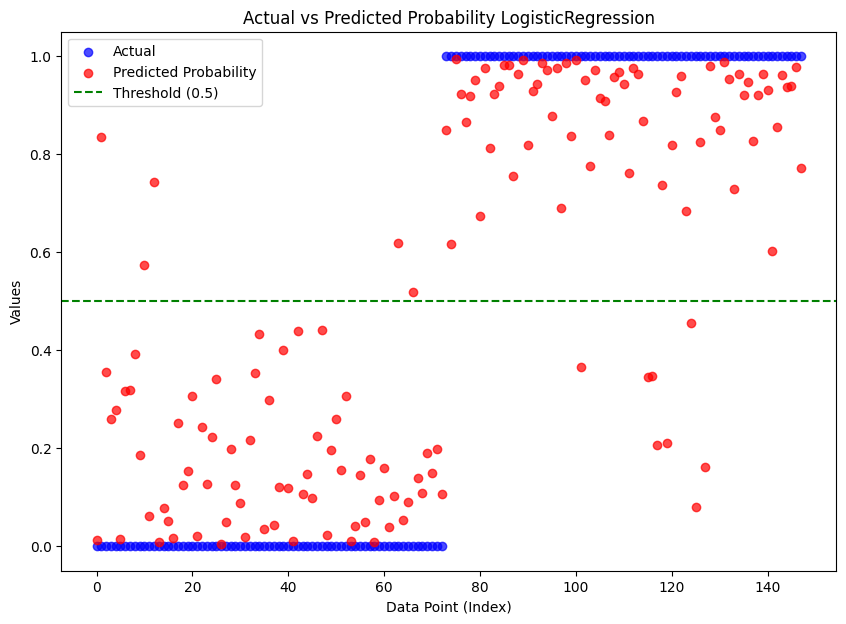

In [18]:
pva_plot_lr = predictedVsActualPlot(table_lr)

Model Accuracy of Logistic Regression is: 0.9122

Confusion Matrix - Logistic Regression
Classification Report - Logistic Regression
              precision    recall  f1-score   support

           1       0.93      0.89      0.91        75
           0       0.89      0.93      0.91        73

    accuracy                           0.91       148
   macro avg       0.91      0.91      0.91       148
weighted avg       0.91      0.91      0.91       148



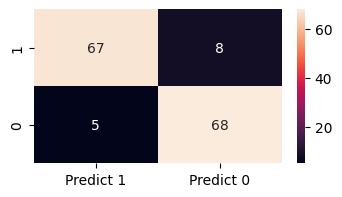

In [19]:
print("Model Accuracy of Logistic Regression is: {0:.4f}".format(model_score_lr))
print()

print("Confusion Matrix - Logistic Regression")
cm=metrics.confusion_matrix(y_test, y_predict_lr, labels=[1, 0])

df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (4,2))
sns.heatmap(df_cm, annot=True)

print("Classification Report - Logistic Regression")
print(metrics.classification_report(y_test, y_predict_lr, labels=[1, 0]))

In [20]:
saveMetricsFinalDf('Logistic Regression', y_test, y_predict_lr)

saveModel(model_lr, 'lr')

# Logistic Regression with Hyperparameter tuning

In [21]:
########Hyperparameter tuning for SVM####################
#List Hyperparameters that we want to tune.
#n_components = list(range(1,X.shape[1]+1,1))
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

#Convert to dictionary
hyperparameters = dict(solver=solvers,penalty=penalty,C=c_values)
#Create new LR object
model_lr_2 = LogisticRegression()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#Use GridSearch
clf = GridSearchCV(model_lr_2, hyperparameters, cv=cv)


#clf = RandomizedSearchCV(knn_2, hyperparameters, n_iter=500, cv=8, scoring="recall")
#Fit the model
best_model_lr_2 = clf.fit(X_train, y_train)
#Print The value of best Hyperparameters
#print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
#print('Best p:', best_model.best_estimator_.get_params()['p'])
#print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print('Best Score: %s' % best_model_lr_2.best_score_)
print('Best Hyperparameters: %s' % best_model_lr_2.best_params_)
print(hyperparameters)


y_pred_lr_2 = best_model_lr_2.predict(X_test)

conf_matrix_knn_2 = confusion_matrix(y_test, y_pred_lr_2)

accuracy_knn_2 = ((conf_matrix_knn_2[0,0] + conf_matrix_knn_2[1,1])/(conf_matrix_knn_2[0,0] +conf_matrix_knn_2[0,1]+conf_matrix_knn_2[1,0]+conf_matrix_knn_2[1,1]))*100


/Users/tomas/Documents/Tese/Predictive-models-Parkinson/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/tomas/Documents/Tese/Predictive-models-Parkinson/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver option

Best Score: 0.94484593837535
Best Hyperparameters: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
{'solver': ['newton-cg', 'lbfgs', 'liblinear'], 'penalty': ['l2'], 'C': [100, 10, 1.0, 0.1, 0.01]}


In [22]:
pd.set_option('display.max_rows', None)
table_lr_2 = predictedVsActualTable(best_model_lr_2, X_test, y_test, type(model_lr_2))


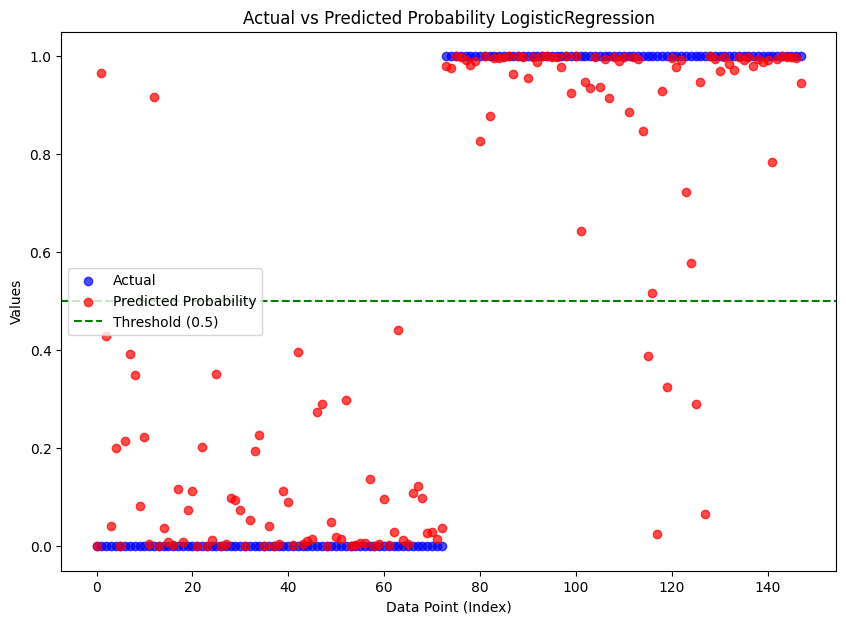

In [23]:
pva_plot_lr_2 = predictedVsActualPlot(table_lr_2)

              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95        73
         1.0       0.97      0.93      0.95        75

    accuracy                           0.95       148
   macro avg       0.95      0.95      0.95       148
weighted avg       0.95      0.95      0.95       148



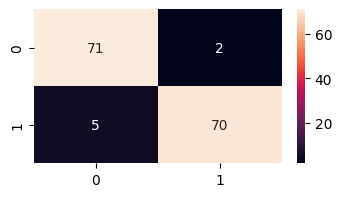

In [24]:

plt.figure(figsize = (4,2))
sns.heatmap(conf_matrix_knn_2, annot=True)


#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_lr_2))
#Checking performance our model with ROC Score.

saveMetricsFinalDf('Logistic Regression (HPT)', y_test, y_pred_lr_2)
saveModel(best_model_lr_2, 'lr_2')

# KNN

In [25]:
# Call Nearest Neighbour algorithm and fit the model on train data
model_knn = KNeighborsClassifier(n_neighbors= 5 , weights = 'distance' )
model_knn.fit(X_train, np.ravel(y_train,order='C'))

# For every test data point, predict it's label based on 5 nearest neighbours in this model. 
#The majority class will be assigned to the test data point

y_predict_knn = model_knn.predict(X_test)
model_score_knn = model_knn.score(X_test, y_test)


In [26]:
table_knn = predictedVsActualTable(model_knn, X_test, y_test)
print(table_knn)


     Actual  Predicted_Probability  Predicted_Class
354     0.0               0.000000              0.0
107     1.0               1.000000              1.0
165     1.0               1.000000              1.0
197     1.0               0.846098              1.0
318     0.0               0.000000              0.0
..      ...                    ...              ...
95      1.0               1.000000              1.0
122     1.0               1.000000              1.0
23      1.0               0.585735              1.0
13      1.0               1.000000              1.0
61      1.0               1.000000              1.0

[148 rows x 3 columns]


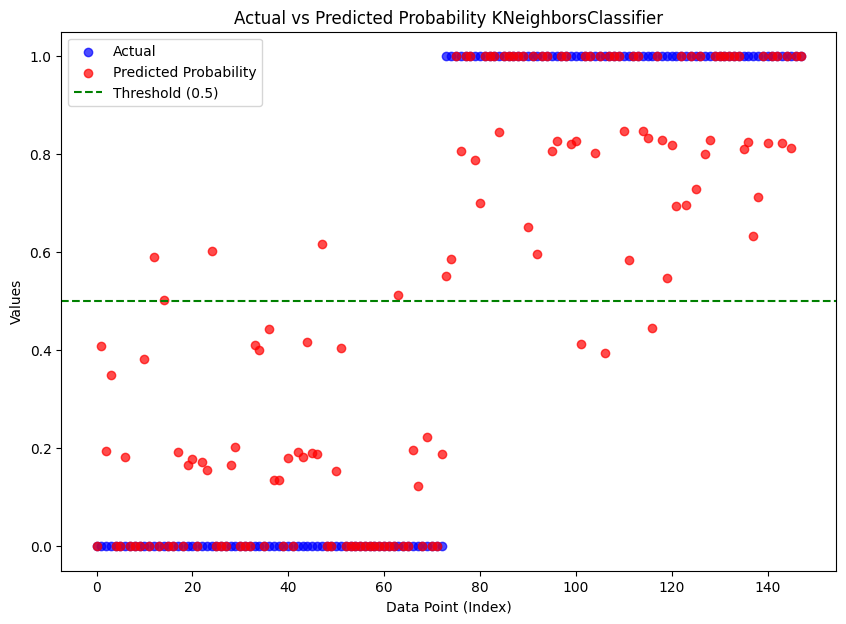

In [27]:
predictedVsActualPlot(table_knn)

Classification Report - KNN
              precision    recall  f1-score   support

           1       0.94      0.96      0.95        75
           0       0.96      0.93      0.94        73

    accuracy                           0.95       148
   macro avg       0.95      0.95      0.95       148
weighted avg       0.95      0.95      0.95       148

Confusion Matrix - KNN


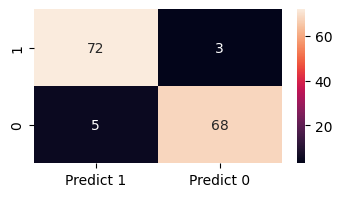

In [28]:
print("Classification Report - KNN")
print(metrics.classification_report(y_test, y_predict_knn, labels=[1, 0]))

print("Confusion Matrix - KNN")
cm=metrics.confusion_matrix(y_test, y_predict_knn, labels=[1, 0])
df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (4,2))
sns.heatmap(df_cm, annot=True)

saveMetricsFinalDf('KNN', y_test, y_predict_knn)
saveModel(model_knn, 'knn')

# KNN with hyperparameter tuning

In [29]:
# Assuming you have X_train, X_test, y_train, and y_test
# If not, replace this with your actual data loading and splitting logic

# Define the parameter grid
param_grid = {
    'n_neighbors': list(range(1, 20)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
}

# Create a KNeighborsClassifier
model_knn_2 = KNeighborsClassifier()

# Create GridSearchCV
clf = GridSearchCV(model_knn_2, param_grid, cv=5, scoring='accuracy')

# Fit the model to the training data
clf.fit(X_train, np.ravel(y_train, order='C'))

# Get the best parameters
best_params = clf.best_params_

# Get the best model
best_model_knn_2 = clf.best_estimator_

# Evaluate the best model on the test set
y_pred_knn_2 = best_model_knn_2.predict(X_test)
model_score_knn = best_model_knn_2.score(X_test, y_test)

# Print the results
print('Best Hyperparameters:', best_params)
print('Best Model Score:', model_score_knn)

Best Hyperparameters: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Best Model Score: 0.9391891891891891


In [30]:
"""leaf_size = list(range(1,50))
n_neighbors = list(range(1,20)) #neighbours must be < number of samples (22)
p=[1,2]
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Create new KNN object
model_knn_2 = KNeighborsClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#Use GridSearch
clf = GridSearchCV(model_knn_2, hyperparameters, cv=10)

#clf = RandomizedSearchCV(model_knn_2, hyperparameters, n_iter=500, cv=8, scoring="recall")
#Fit the model
best_model_knn_2 = clf.fit(X_train, y_train)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model_knn_2.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model_knn_2.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model_knn_2.best_estimator_.get_params()['n_neighbors'])
print('Best Score: %s' % best_model_knn_2.best_score_)
print('Best Hyperparameters: %s' % best_model_knn_2.best_params_)
print(hyperparameters)
y_pred_knn_2 = best_model_knn_2.predict(X_test)
"""


'leaf_size = list(range(1,50))\nn_neighbors = list(range(1,20)) #neighbours must be < number of samples (22)\np=[1,2]\n#Convert to dictionary\nhyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)\n#Create new KNN object\nmodel_knn_2 = KNeighborsClassifier()\n\ncv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)\n\n#Use GridSearch\nclf = GridSearchCV(model_knn_2, hyperparameters, cv=10)\n\n#clf = RandomizedSearchCV(model_knn_2, hyperparameters, n_iter=500, cv=8, scoring="recall")\n#Fit the model\nbest_model_knn_2 = clf.fit(X_train, y_train)\n#Print The value of best Hyperparameters\nprint(\'Best leaf_size:\', best_model_knn_2.best_estimator_.get_params()[\'leaf_size\'])\nprint(\'Best p:\', best_model_knn_2.best_estimator_.get_params()[\'p\'])\nprint(\'Best n_neighbors:\', best_model_knn_2.best_estimator_.get_params()[\'n_neighbors\'])\nprint(\'Best Score: %s\' % best_model_knn_2.best_score_)\nprint(\'Best Hyperparameters: %s\' % best_model_knn_2.b

In [31]:
table_knn_2 = predictedVsActualTable(best_model_knn_2, X_test, y_test, type(model_knn_2))
print(table_knn_2)

     Actual  Predicted_Probability  Predicted_Class
354     0.0               0.000000              0.0
107     1.0               1.000000              1.0
165     1.0               1.000000              1.0
197     1.0               1.000000              1.0
318     0.0               0.000000              0.0
..      ...                    ...              ...
95      1.0               1.000000              1.0
122     1.0               1.000000              1.0
23      1.0               0.248947              0.0
13      1.0               1.000000              1.0
61      1.0               1.000000              1.0

[148 rows x 3 columns]


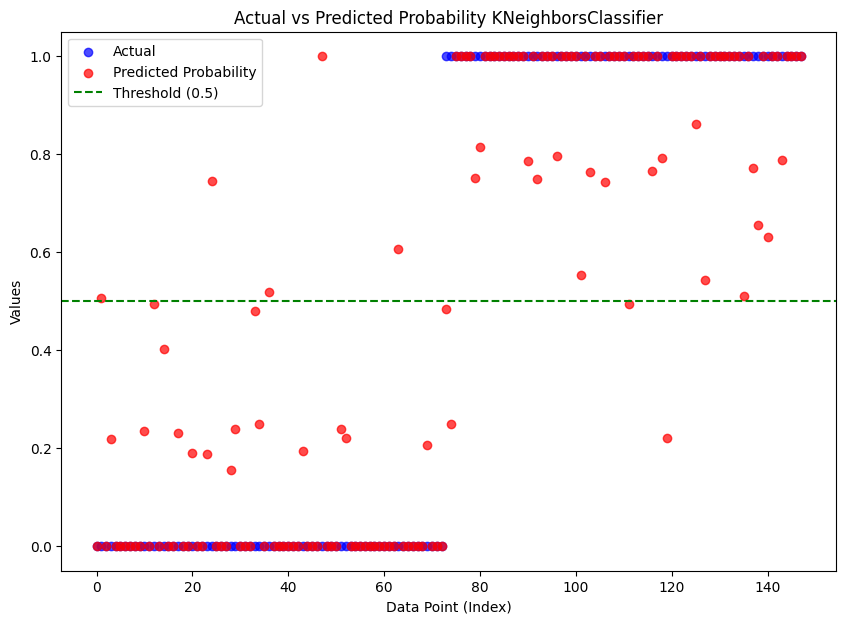

In [32]:
predictedVsActualPlot(table_knn_2)

93.91891891891892
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94        73
         1.0       0.93      0.95      0.94        75

    accuracy                           0.94       148
   macro avg       0.94      0.94      0.94       148
weighted avg       0.94      0.94      0.94       148



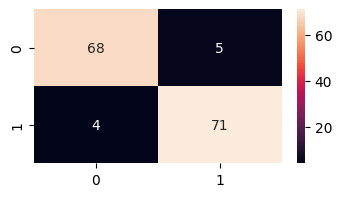

In [33]:

conf_matrix_knn_2 = confusion_matrix(y_test, y_pred_knn_2)

accuracy_knn_2 = ((conf_matrix_knn_2[0,0] + conf_matrix_knn_2[1,1])/(conf_matrix_knn_2[0,0] +conf_matrix_knn_2[0,1]+conf_matrix_knn_2[1,0]+conf_matrix_knn_2[1,1]))*100


print(accuracy_knn_2)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_knn_2))
#Checking performance our model with ROC Score.

plt.figure(figsize = (4,2))
sns.heatmap(conf_matrix_knn_2, annot=True)

saveMetricsFinalDf('KNN (HPT)', y_test, y_pred_knn_2)
saveModel(best_model_knn_2, 'knn_2')

# Naive Bayes

### No important parameters to tune

In [34]:
model_nb = GaussianNB()
model_nb.fit(X_train, y_train)
y_predict_nb = model_nb.predict(X_test)
model_score_nb=metrics.accuracy_score(y_test, y_predict_nb)


In [35]:
table_nb = predictedVsActualTable(model_nb, X_test, y_test)
table_nb.Name = type(GaussianNB()).__name__
print(table_nb)

     Actual  Predicted_Probability  Predicted_Class
354     0.0               0.000083              0.0
107     1.0               1.000000              1.0
165     1.0               0.999922              1.0
197     1.0               0.998156              1.0
318     0.0               0.000065              0.0
..      ...                    ...              ...
95      1.0               1.000000              1.0
122     1.0               0.999124              1.0
23      1.0               0.522339              1.0
13      1.0               0.999963              1.0
61      1.0               0.999752              1.0

[148 rows x 3 columns]


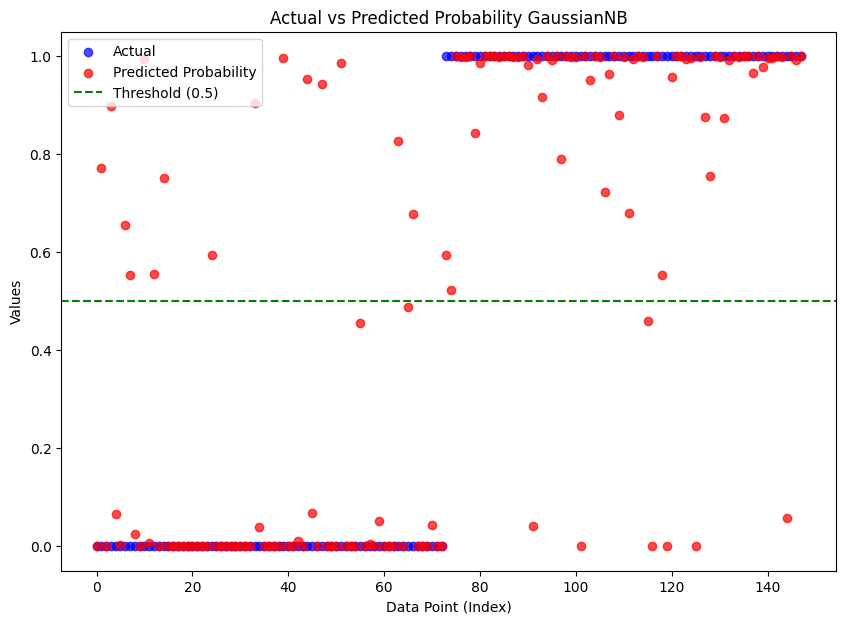

In [36]:
predictedVsActualPlot(table_nb)

Confusion Matrix - Naive Bayes
Classification Report - Naive Bayes
              precision    recall  f1-score   support

           1       0.82      0.91      0.86        75
           0       0.89      0.79      0.84        73

    accuracy                           0.85       148
   macro avg       0.86      0.85      0.85       148
weighted avg       0.86      0.85      0.85       148



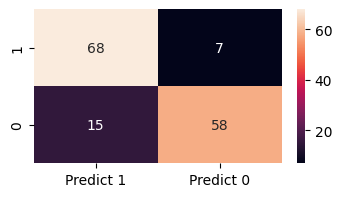

In [37]:
print("Confusion Matrix - Naive Bayes")
cm=metrics.confusion_matrix(y_test, y_predict_nb, labels=[1, 0])
df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (4,2))
sns.heatmap(df_cm, annot=True)

print("Classification Report - Naive Bayes")
print(metrics.classification_report(y_test, y_predict_nb, labels=[1, 0]))

saveMetricsFinalDf('NB', y_test, y_predict_nb)
saveModel(model_nb, 'nb')

# SVM

In [38]:
model_svm = svm.SVC(gamma=0.025, C=3, probability=True)
model_svm.fit(X_train , y_train)
y_predict_svm = model_svm.predict(X_test)
model_score_svm=metrics.accuracy_score(y_test, y_predict_svm)


In [39]:
table_svm = predictedVsActualTable(model_svm, X_test, y_test)
print(table_svm)

     Actual  Predicted_Probability  Predicted_Class
354     0.0               0.000760              0.0
107     1.0               0.999982              1.0
165     1.0               0.953619              1.0
197     1.0               0.987562              1.0
318     0.0               0.015997              0.0
..      ...                    ...              ...
95      1.0               0.967311              1.0
122     1.0               0.954932              1.0
23      1.0               0.688378              1.0
13      1.0               0.999989              1.0
61      1.0               0.977001              1.0

[148 rows x 3 columns]


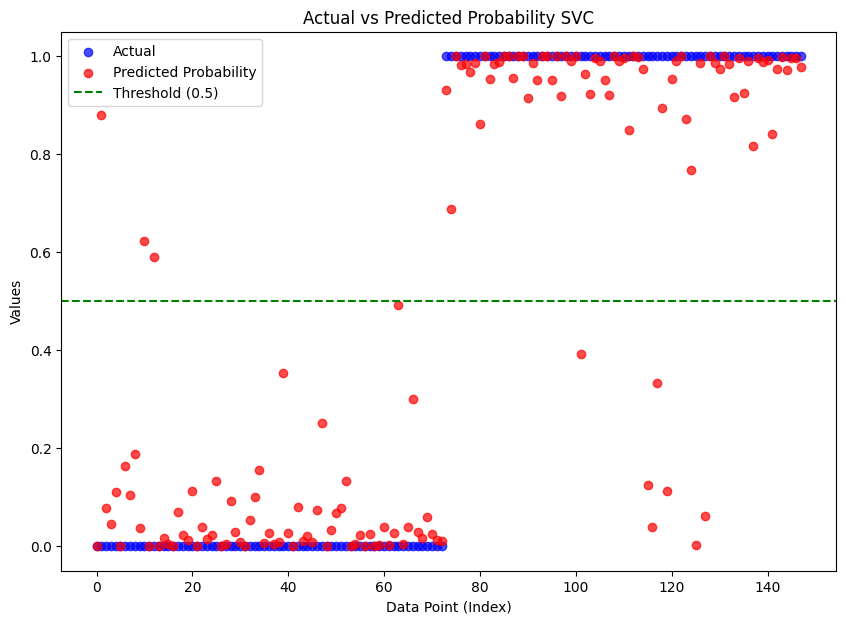

In [40]:
predictedVsActualPlot(table_svm)

Confusion Matrix - SVM
Classification Report - SVM
              precision    recall  f1-score   support

           1       0.94      0.91      0.93        75
           0       0.91      0.95      0.93        73

    accuracy                           0.93       148
   macro avg       0.93      0.93      0.93       148
weighted avg       0.93      0.93      0.93       148



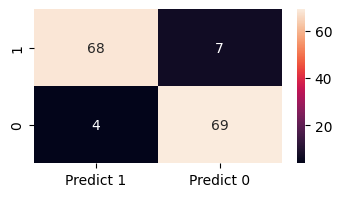

In [41]:
print("Confusion Matrix - SVM")
cm=metrics.confusion_matrix(y_test, y_predict_svm, labels=[1, 0])
df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (4,2))
sns.heatmap(df_cm, annot=True)

print("Classification Report - SVM")
print(metrics.classification_report(y_test, y_predict_svm, labels=[1, 0]))

saveMetricsFinalDf('SVM', y_test, y_predict_svm)
saveModel(model_svm, 'svm')

# SVM with hyperparameter tuning

In [42]:
########Hyperparameter tuning for SVM####################
#List Hyperparameters that we want to tune.
#n_components = list(range(1,X.shape[1]+1,1))
C = [0.1, 1, 10, 100, 1000]
gamma = [1, 0.1, 0.01, 0.001, 0.0001]
kernel = ['rbf']

#Convert to dictionary
hyperparameters = dict(C=C, gamma=gamma, kernel=kernel)
#Create new SVM object
model_svm_2 = svm.SVC(probability=True)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#Use GridSearch
clf = GridSearchCV(model_svm_2, hyperparameters, refit=True)

#clf = RandomizedSearchCV(knn_2, hyperparameters, n_iter=500, cv=8, scoring="recall")
#Fit the model
best_model_svm_2 = clf.fit(X_train, y_train)
#Print The value of best Hyperparameters
#print('Best leaf_size:', best_model_svm_2.best_estimator_.get_params()['leaf_size'])
#print('Best p:', best_model_svm_2.best_estimator_.get_params()['p'])
#print('Best n_neighbors:', best_model_svm_2.best_estimator_.get_params()['n_neighbors'])
print('Best Score: %s' % best_model_svm_2.best_score_)
print('Best Hyperparameters: %s' % best_model_svm_2.best_params_)
print(hyperparameters)
y_pred_svm_2 = best_model_svm_2.predict(X_test)

conf_matrix_svm_2 = confusion_matrix(y_test, y_pred_svm_2)

accuracy_svm_2 = ((conf_matrix_svm_2[0,0] + conf_matrix_svm_2[1,1])/(conf_matrix_svm_2[0,0] +conf_matrix_svm_2[0,1]+conf_matrix_svm_2[1,0]+conf_matrix_svm_2[1,1]))*100


Best Score: 0.9855072463768118
Best Hyperparameters: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
{'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}


In [43]:
table_svm_2 = predictedVsActualTable(best_model_lr_2, X_test, y_test, type(model_svm_2))
print(table_svm_2)

     Actual  Predicted_Probability  Predicted_Class
354     0.0               0.000836              0.0
107     1.0               0.999861              1.0
165     1.0               0.877090              1.0
197     1.0               0.995563              1.0
318     0.0               0.099395              0.0
..      ...                    ...              ...
95      1.0               0.982252              1.0
122     1.0               0.963374              1.0
23      1.0               0.975450              1.0
13      1.0               0.997734              1.0
61      1.0               0.946051              1.0

[148 rows x 3 columns]


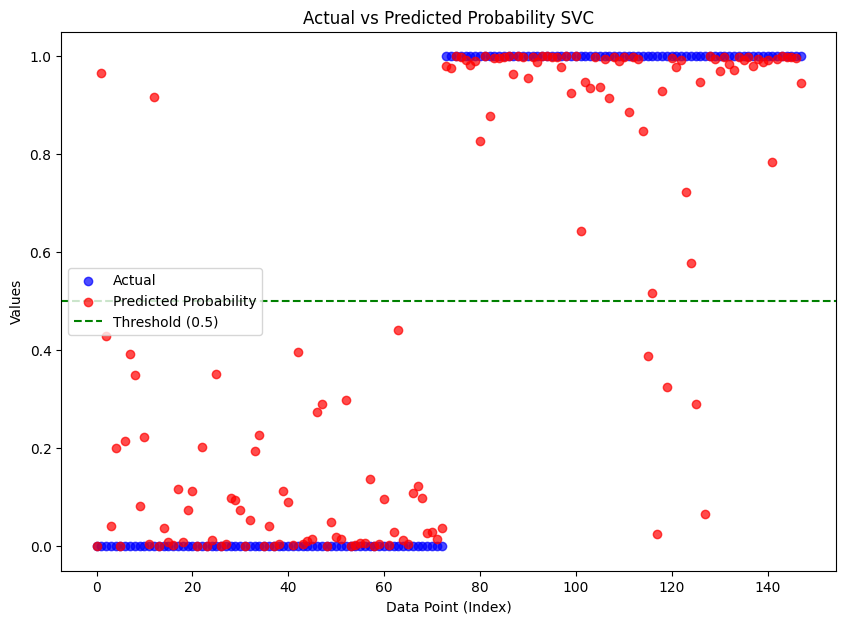

In [44]:
predictedVsActualPlot(table_svm_2)

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97        73
         1.0       0.97      0.97      0.97        75

    accuracy                           0.97       148
   macro avg       0.97      0.97      0.97       148
weighted avg       0.97      0.97      0.97       148



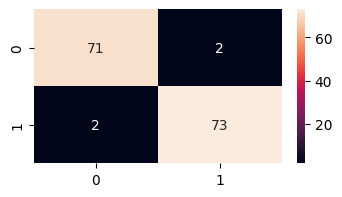

In [45]:
#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_svm_2))
#Checking performance our model with ROC Score.


plt.figure(figsize = (4,2))
sns.heatmap(conf_matrix_svm_2, annot=True)

saveMetricsFinalDf('SVM (HPT)', y_test, y_pred_svm_2)
saveModel(best_model_svm_2, 'svm_2')

# Random Forest

In [46]:
model_rf = RandomForestClassifier(n_estimators = 50,random_state=1,max_features=3) 
model_rf = model_rf.fit(X_train, y_train)
y_predict_rf = model_rf.predict(X_test)
print(model_rf.score(X_test, y_test))

0.9527027027027027


In [47]:
table_rf = predictedVsActualTable(model_rf, X_test, y_test)
print(table_rf)

     Actual  Predicted_Probability  Predicted_Class
354     0.0                   0.06              0.0
107     1.0                   0.98              1.0
165     1.0                   0.94              1.0
197     1.0                   0.86              1.0
318     0.0                   0.18              0.0
..      ...                    ...              ...
95      1.0                   0.88              1.0
122     1.0                   1.00              1.0
23      1.0                   0.60              1.0
13      1.0                   0.96              1.0
61      1.0                   0.86              1.0

[148 rows x 3 columns]


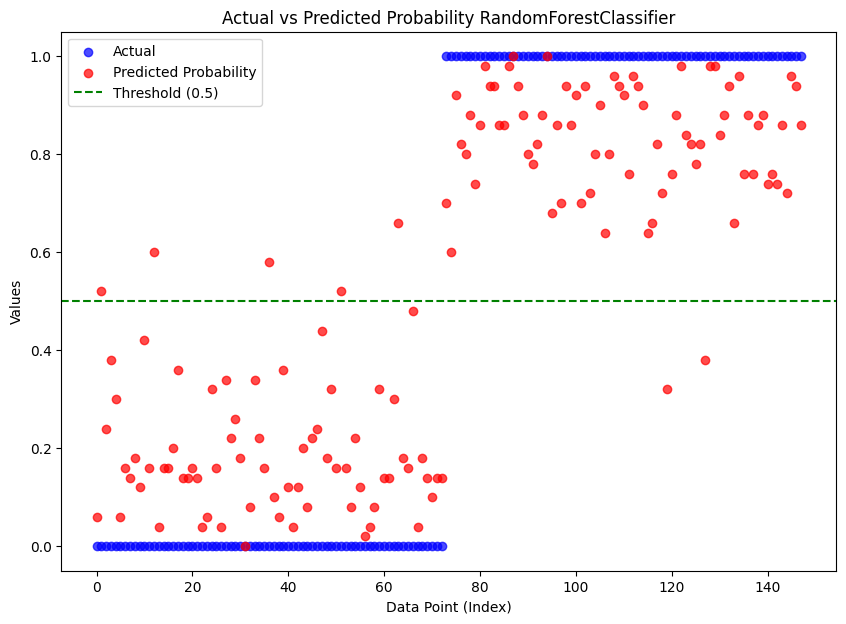

In [48]:
predictedVsActualPlot(table_rf)

Confusion Matrix -Random Forest


<Axes: >

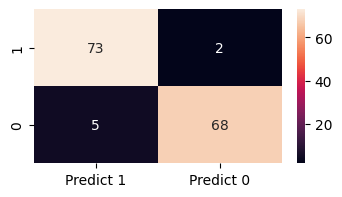

In [49]:
print("Confusion Matrix -Random Forest")
cm=metrics.confusion_matrix(y_test, y_predict_rf, labels=[1, 0])
df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (4,2))
sns.heatmap(df_cm, annot=True)

In [50]:
print("Classification Report - Random Forest")
print(metrics.classification_report(y_test, y_predict_rf, labels=[1, 0]))

saveMetricsFinalDf('Random Forest', y_test, y_predict_rf)
saveModel(model_rf, 'rf')

Classification Report - Random Forest
              precision    recall  f1-score   support

           1       0.94      0.97      0.95        75
           0       0.97      0.93      0.95        73

    accuracy                           0.95       148
   macro avg       0.95      0.95      0.95       148
weighted avg       0.95      0.95      0.95       148



# Random Forest with Hyperparameter Tuning

In [51]:
#TODO

# Bagging

In [52]:
model_bgcl = BaggingClassifier(n_estimators=50,random_state=1)
model_bgcl = model_bgcl.fit(X_train, y_train)
y_predict_bag = model_bgcl.predict(X_test)
print(model_bgcl.score(X_test , y_test))

0.9459459459459459


In [53]:
table_bgcl = predictedVsActualTable(model_bgcl, X_test, y_test)
print(table_bgcl)

     Actual  Predicted_Probability  Predicted_Class
354     0.0                   0.00              0.0
107     1.0                   1.00              1.0
165     1.0                   0.88              1.0
197     1.0                   0.94              1.0
318     0.0                   0.42              0.0
..      ...                    ...              ...
95      1.0                   1.00              1.0
122     1.0                   1.00              1.0
23      1.0                   0.88              1.0
13      1.0                   1.00              1.0
61      1.0                   0.98              1.0

[148 rows x 3 columns]


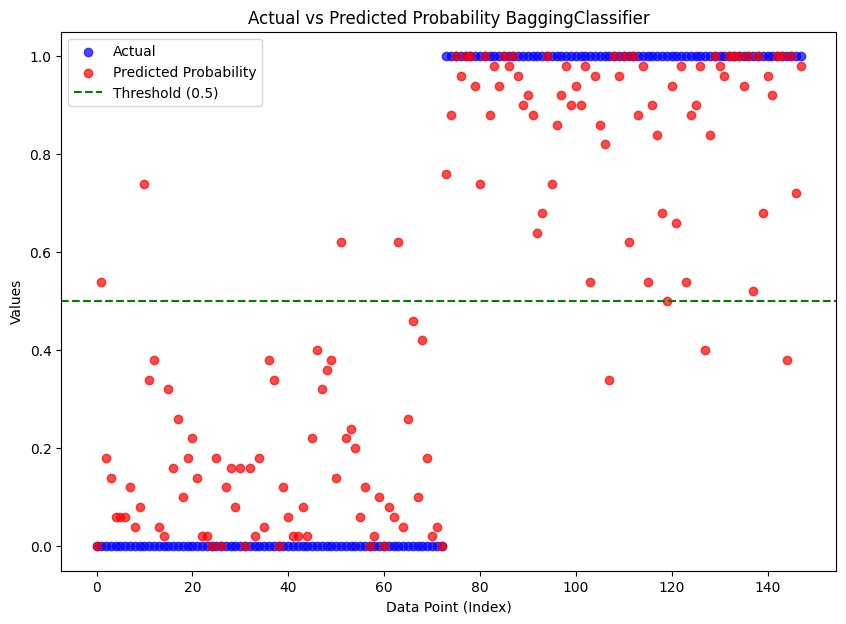

In [54]:
predictedVsActualPlot(table_bgcl)

Confusion Matrix -Bagging Classifier
Classification Report - Bagging Classifier
              precision    recall  f1-score   support

           1       0.95      0.95      0.95        75
           0       0.95      0.95      0.95        73

    accuracy                           0.95       148
   macro avg       0.95      0.95      0.95       148
weighted avg       0.95      0.95      0.95       148



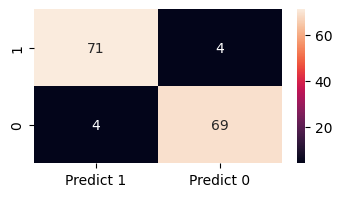

In [55]:
print("Confusion Matrix -Bagging Classifier")
cm=metrics.confusion_matrix(y_test, y_predict_bag, labels=[1, 0])
df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (4,2))
sns.heatmap(df_cm, annot=True)

print("Classification Report - Bagging Classifier")
print(metrics.classification_report(y_test, y_predict_bag, labels=[1, 0]))

saveMetricsFinalDf('Bagging', y_test, y_predict_bag)
saveModel(model_bgcl, 'bgcl')

# Bagging with Hyperparameter Tuning

In [56]:
#TESTE


# Define the Bagging Classifier with hyperparameters to be tuned
model_bgcl_2 = BaggingClassifier(random_state=1)

# Define the hyperparameters grid to search
param_grid = {
    'n_estimators': [10, 20, 30, 40, 50],  # Adjust the number of estimators
    # You can add more hyperparameters to tune here
}

# Define the scoring method, e.g., accuracy
scoring = make_scorer(accuracy_score)

# Create the Grid Search object
grid_search = GridSearchCV(model_bgcl_2, param_grid, scoring=scoring, cv=5)

# Fit the Grid Search to your training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best Bagging Classifier model
best_model_bgcl_2 = grid_search.best_estimator_

# Fit the best model on the training data
best_model_bgcl_2.fit(X_train, y_train)

# Make predictions on the test set
y_predict_bag_2 = best_model_bgcl_2.predict(X_test)


Best Hyperparameters: {'n_estimators': 50}


In [57]:
table_bgcl_2 = predictedVsActualTable(best_model_bgcl_2, X_test, y_test, type(model_bgcl_2))
print(table_bgcl_2)

     Actual  Predicted_Probability  Predicted_Class
354     0.0                   0.00              0.0
107     1.0                   1.00              1.0
165     1.0                   0.88              1.0
197     1.0                   0.94              1.0
318     0.0                   0.42              0.0
..      ...                    ...              ...
95      1.0                   1.00              1.0
122     1.0                   1.00              1.0
23      1.0                   0.88              1.0
13      1.0                   1.00              1.0
61      1.0                   0.98              1.0

[148 rows x 3 columns]


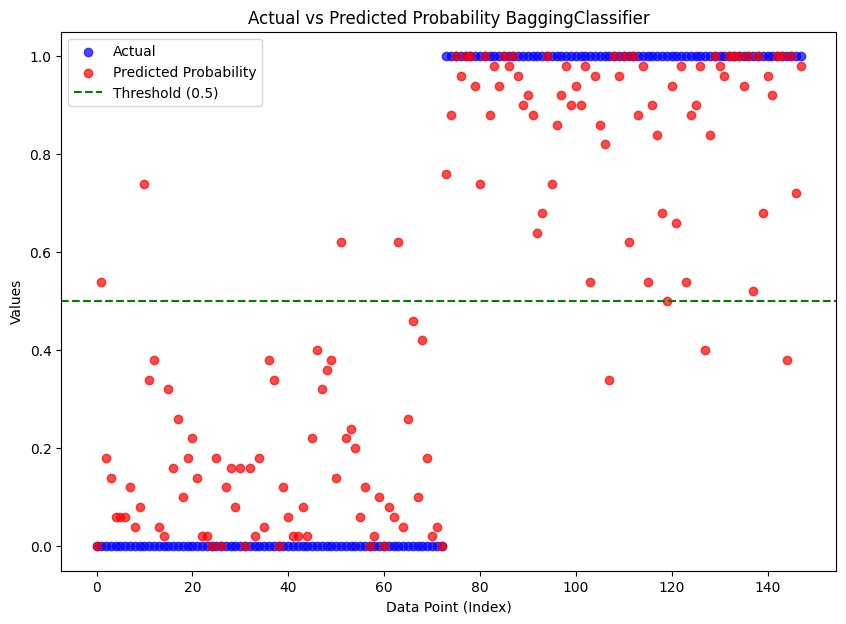

In [58]:
predictedVsActualPlot(table_bgcl_2)

Confusion Matrix - Bagging Classifier
Classification Report - Bagging Classifier
              precision    recall  f1-score   support

           1       0.95      0.95      0.95        75
           0       0.95      0.95      0.95        73

    accuracy                           0.95       148
   macro avg       0.95      0.95      0.95       148
weighted avg       0.95      0.95      0.95       148



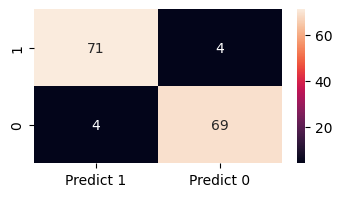

In [59]:

# Compute and print the confusion matrix
print("Confusion Matrix - Bagging Classifier")
cm = confusion_matrix(y_test, y_predict_bag_2, labels=[1, 0])
df_cm = pd.DataFrame(cm, index=["1", "0"], columns=["Predict 1", "Predict 0"])
plt.figure(figsize=(4, 2))
sns.heatmap(df_cm, annot=True)

# Print the classification report
print("Classification Report - Bagging Classifier")
print(classification_report(y_test, y_predict_bag_2, labels=[1, 0]))

saveMetricsFinalDf('Bagging (HPT)', y_test, y_predict_bag_2)
saveModel(best_model_bgcl_2, 'bgcl_2')


# AdaBoost

In [60]:
model_adabc = AdaBoostClassifier(n_estimators=50, random_state=1)
#abcl = AdaBoostClassifier( n_estimators=50,random_state=1)
model_adabc = model_adabc.fit(X_train, y_train)
y_predict_ada = model_adabc.predict(X_test)


In [61]:
table_adabc = predictedVsActualTable(model_adabc, X_test, y_test)
print(table_adabc)

     Actual  Predicted_Probability  Predicted_Class
354     0.0               0.384041              0.0
107     1.0               0.758927              1.0
165     1.0               0.563052              1.0
197     1.0               0.586652              1.0
318     0.0               0.481663              0.0
..      ...                    ...              ...
95      1.0               0.595158              1.0
122     1.0               0.570241              1.0
23      1.0               0.682916              1.0
13      1.0               0.601063              1.0
61      1.0               0.720271              1.0

[148 rows x 3 columns]


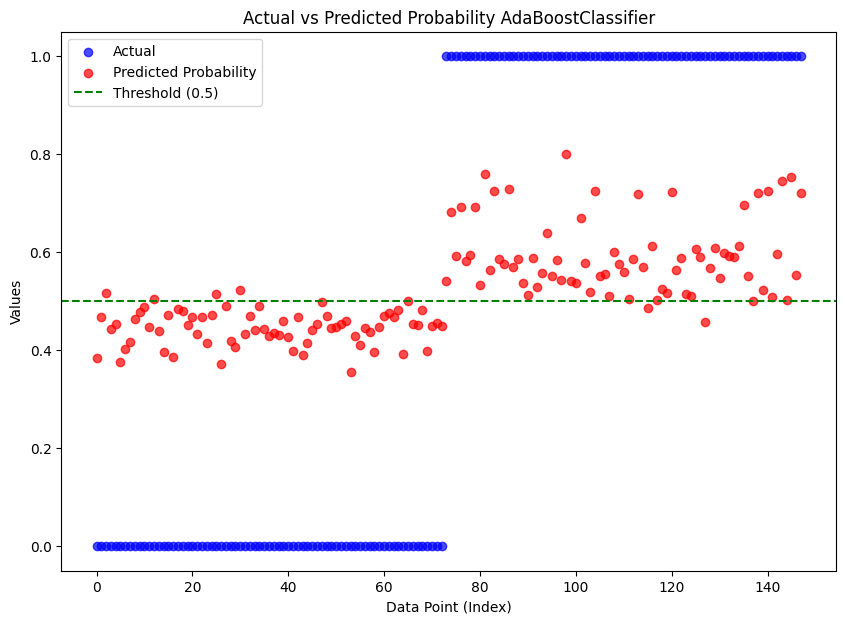

In [62]:
predictedVsActualPlot(table_adabc)

Confusion Matrix -Ada Boost
Classification Report - Ada Boost
              precision    recall  f1-score   support

           1       0.94      0.97      0.95        75
           0       0.97      0.93      0.95        73

    accuracy                           0.95       148
   macro avg       0.95      0.95      0.95       148
weighted avg       0.95      0.95      0.95       148



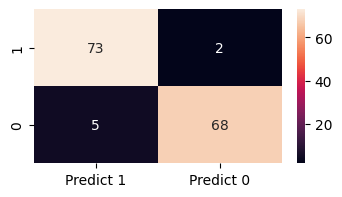

In [63]:
print("Confusion Matrix -Ada Boost")
cm=metrics.confusion_matrix(y_test, y_predict_ada, labels=[1, 0])
df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (4,2))
sns.heatmap(df_cm, annot=True)

print("Classification Report - Ada Boost")
print(metrics.classification_report(y_test, y_predict_ada, labels=[1, 0]))

saveMetricsFinalDf('AdaBoost', y_test, y_predict_ada)
saveModel(model_adabc, 'adabc')

# AdaBoost with Hyperparameter Tuning

In [64]:
#TESTE


# Define the AdaBoost Classifier with hyperparameters to be tuned
model_adabc_2 = AdaBoostClassifier(random_state=1)

# Define the hyperparameters grid to search
param_grid = {
    'n_estimators': [10, 20, 30, 40, 50],  # Adjust the number of estimators
    # You can add more hyperparameters to tune here
}

# Define the scoring method, e.g., accuracy
scoring = make_scorer(accuracy_score)

# Create the Grid Search object
grid_search = GridSearchCV(model_adabc_2, param_grid, scoring=scoring, cv=5)

# Fit the Grid Search to your training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best AdaBoost Classifier model
best_model_adabc_2 = grid_search.best_estimator_

# Fit the best model on the training data
best_model_adabc_2.fit(X_train, y_train)

# Make predictions on the test set
y_predict_ada_2 = best_model_adabc_2.predict(X_test)



Best Hyperparameters: {'n_estimators': 50}


In [65]:
table_adabc_2 = predictedVsActualTable(best_model_adabc_2, X_test, y_test, type(model_adabc_2))
print(table_adabc_2)

     Actual  Predicted_Probability  Predicted_Class
354     0.0               0.384041              0.0
107     1.0               0.758927              1.0
165     1.0               0.563052              1.0
197     1.0               0.586652              1.0
318     0.0               0.481663              0.0
..      ...                    ...              ...
95      1.0               0.595158              1.0
122     1.0               0.570241              1.0
23      1.0               0.682916              1.0
13      1.0               0.601063              1.0
61      1.0               0.720271              1.0

[148 rows x 3 columns]


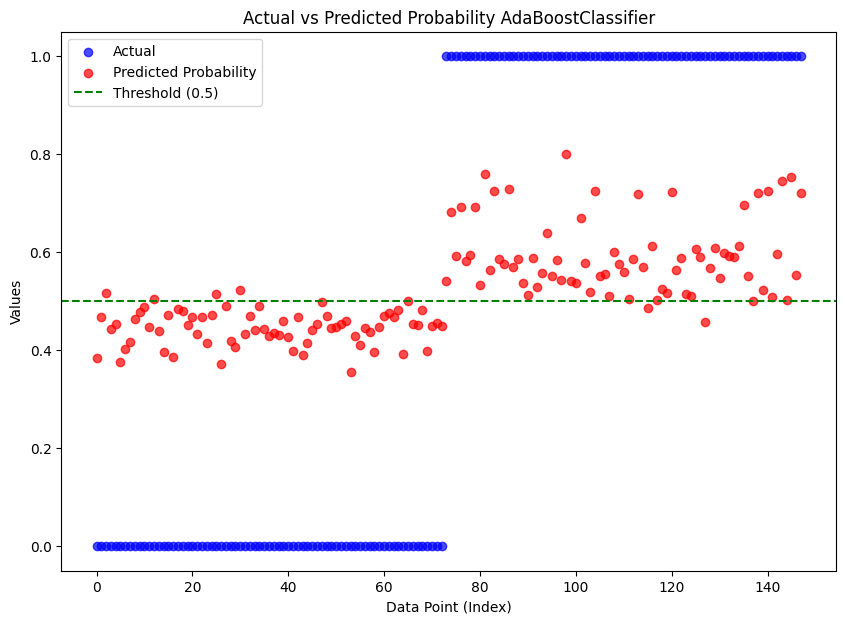

In [66]:
predictedVsActualPlot(table_adabc_2)

Confusion Matrix - Ada Boost
Classification Report - Ada Boost
              precision    recall  f1-score   support

           1       0.94      0.97      0.95        75
           0       0.97      0.93      0.95        73

    accuracy                           0.95       148
   macro avg       0.95      0.95      0.95       148
weighted avg       0.95      0.95      0.95       148



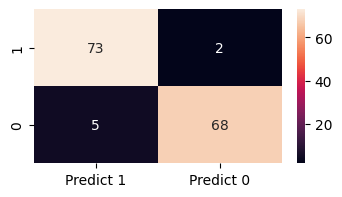

In [67]:

# Compute and print the confusion matrix
print("Confusion Matrix - Ada Boost")
cm = confusion_matrix(y_test, y_predict_ada_2, labels=[1, 0])
df_cm = pd.DataFrame(cm, index=["1", "0"], columns=["Predict 1", "Predict 0"])
plt.figure(figsize=(4, 2))
sns.heatmap(df_cm, annot=True)

# Print the classification report
print("Classification Report - Ada Boost")
print(classification_report(y_test, y_predict_ada_2, labels=[1, 0]))

saveMetricsFinalDf('AdaBoost (HPT)', y_test, y_predict_ada_2)
saveModel(best_model_adabc_2, 'adabc_2')


# XG Boost

In [68]:
model_xgbc = XGBClassifier(random_state=0, learning_rate=0.1, n_estimators=100, max_depth=4)
model_xgbc = model_xgbc.fit(X_train, y_train)
y_predict_XGB = model_xgbc.predict(X_test)


/Users/tomas/Documents/Tese/Predictive-models-Parkinson/venv/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/tomas/Documents/Tese/Predictive-models-Parkinson/venv/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/tomas/Documents/Tese/Predictive-models-Parkinson/venv/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/tomas/Documents/Tese/Predictive-models-Parkinson/venv/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_cate

In [69]:
table_xgbc = predictedVsActualTable(model_xgbc, X_test, y_test)
print(table_xgbc)

     Actual  Predicted_Probability  Predicted_Class
354     0.0               0.001866                0
107     1.0               0.998383                1
165     1.0               0.928174                1
197     1.0               0.951234                1
318     0.0               0.171028                0
..      ...                    ...              ...
95      1.0               0.993061                1
122     1.0               0.995125                1
23      1.0               0.986577                1
13      1.0               0.997470                1
61      1.0               0.996008                1

[148 rows x 3 columns]


/Users/tomas/Documents/Tese/Predictive-models-Parkinson/venv/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/tomas/Documents/Tese/Predictive-models-Parkinson/venv/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/tomas/Documents/Tese/Predictive-models-Parkinson/venv/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/tomas/Documents/Tese/Predictive-models-Parkinson/venv/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_cate

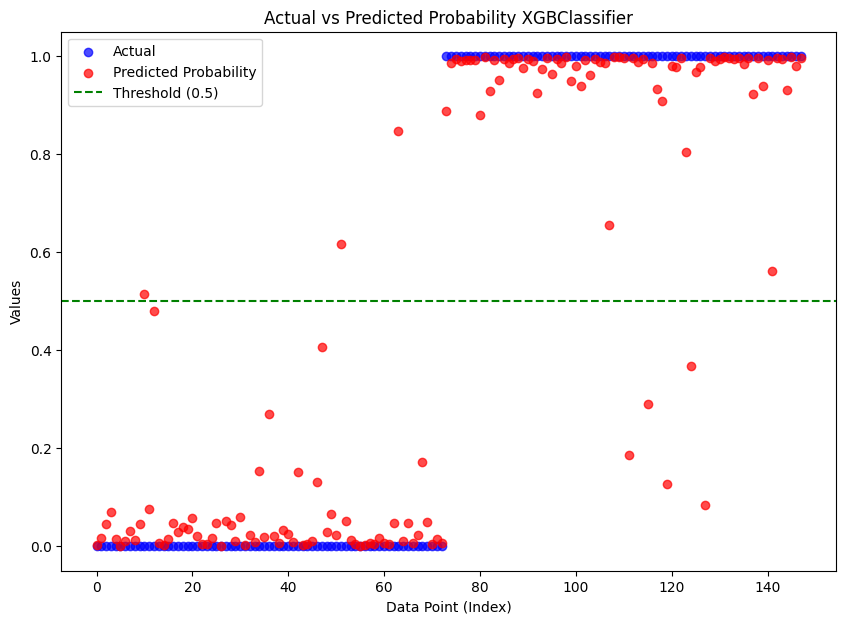

In [70]:
predictedVsActualPlot(table_xgbc)

Confusion Matrix - XGB Classifier
Classification Report - XGB Classifier
              precision    recall  f1-score   support

           1       0.96      0.93      0.95        75
           0       0.93      0.96      0.95        73

    accuracy                           0.95       148
   macro avg       0.95      0.95      0.95       148
weighted avg       0.95      0.95      0.95       148



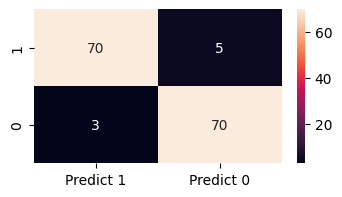

In [71]:
print("Confusion Matrix - XGB Classifier")
cm=metrics.confusion_matrix(y_test, y_predict_XGB, labels=[1, 0])
df_cm = pd.DataFrame(cm, index = [i for i in ["1","0"]],
                  columns = [i for i in ["Predict 1","Predict 0"]])
plt.figure(figsize = (4,2))
sns.heatmap(df_cm, annot=True)

print("Classification Report - XGB Classifier")
print(metrics.classification_report(y_test, y_predict_XGB, labels=[1, 0]))

saveMetricsFinalDf('XGBoost', y_test, y_predict_XGB)
saveModel(model_xgbc, 'xgbc')

# XGBoost with Hyperparameter tuning

In [72]:

# Define the XGBClassifier with hyperparameters to be tuned
model_xgbc_2 = XGBClassifier(random_state=0)

# Define the hyperparameters grid to search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],  # Adjust the learning rate
    'n_estimators': [50, 100, 200],  # Adjust the number of estimators
    'max_depth': [3, 4, 5]  # Adjust the maximum depth of trees
    # You can add more hyperparameters to tune here
}

# Define the scoring method, e.g., accuracy
scoring = make_scorer(accuracy_score)

# Create the Grid Search object
grid_search = GridSearchCV(model_xgbc_2, param_grid, scoring=scoring, cv=5)

# Fit the Grid Search to your training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best XGBClassifier model
best_model_xgbc_2 = grid_search.best_estimator_

# Fit the best model on the training data
best_model_xgbc_2.fit(X_train, y_train)


# Make predictions on the test set
y_predict_XGB_2 = best_model_xgbc_2.predict(X_test)



/Users/tomas/Documents/Tese/Predictive-models-Parkinson/venv/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/tomas/Documents/Tese/Predictive-models-Parkinson/venv/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/tomas/Documents/Tese/Predictive-models-Parkinson/venv/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/tomas/Documents/Tese/Predictive-models-Parkinson/venv/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_cate

Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100}


/Users/tomas/Documents/Tese/Predictive-models-Parkinson/venv/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/tomas/Documents/Tese/Predictive-models-Parkinson/venv/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/tomas/Documents/Tese/Predictive-models-Parkinson/venv/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/tomas/Documents/Tese/Predictive-models-Parkinson/venv/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_cate

In [73]:
table_xgbc_2 = predictedVsActualTable(best_model_xgbc_2, X_test, y_test)
print(table_xgbc_2)

     Actual  Predicted_Probability  Predicted_Class
354     0.0               0.000368                0
107     1.0               0.999525                1
165     1.0               0.946803                1
197     1.0               0.957566                1
318     0.0               0.108507                0
..      ...                    ...              ...
95      1.0               0.995510                1
122     1.0               0.997453                1
23      1.0               0.977685                1
13      1.0               0.999240                1
61      1.0               0.998413                1

[148 rows x 3 columns]


/Users/tomas/Documents/Tese/Predictive-models-Parkinson/venv/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/tomas/Documents/Tese/Predictive-models-Parkinson/venv/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/tomas/Documents/Tese/Predictive-models-Parkinson/venv/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/tomas/Documents/Tese/Predictive-models-Parkinson/venv/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_cate

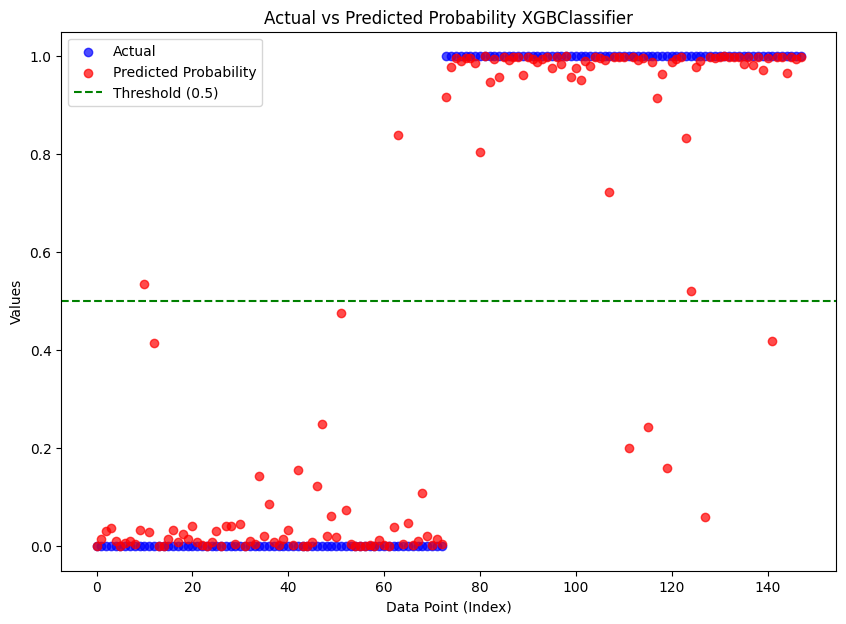

In [74]:
predictedVsActualPlot(table_xgbc_2)

Confusion Matrix - XGB Classifier
Classification Report - XGB Classifier
              precision    recall  f1-score   support

           1       0.97      0.93      0.95        75
           0       0.93      0.97      0.95        73

    accuracy                           0.95       148
   macro avg       0.95      0.95      0.95       148
weighted avg       0.95      0.95      0.95       148



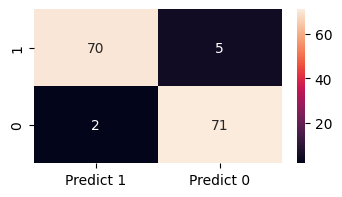

In [75]:
# Compute and print the confusion matrix
print("Confusion Matrix - XGB Classifier")
cm = confusion_matrix(y_test, y_predict_XGB_2, labels=[1, 0])
df_cm = pd.DataFrame(cm, index=["1", "0"], columns=["Predict 1", "Predict 0"])
plt.figure(figsize=(4,2))
sns.heatmap(df_cm, annot=True)

# Print the classification report
print("Classification Report - XGB Classifier")
print(classification_report(y_test, y_predict_XGB_2, labels=[1, 0]))


saveMetricsFinalDf('XGBoost (HPT)', y_test, y_predict_XGB_2)
saveModel(best_model_xgbc_2, 'xgbc_2')


# Final Results

In [76]:
(final_results_df)

,accuracy,precision,recall,f1-score
Logistic Regression,0.91,0.91,0.91,0.91
Logistic Regression (HPT),0.95,0.95,0.95,0.95
KNN,0.95,0.95,0.95,0.95
KNN (HPT),0.94,0.94,0.94,0.94
NB,0.85,0.86,0.85,0.85
SVM,0.93,0.93,0.93,0.93
SVM (HPT),0.97,0.97,0.97,0.97
Random Forest,0.95,0.95,0.95,0.95
Bagging,0.95,0.95,0.95,0.95
Bagging (HPT),0.95,0.95,0.95,0.95


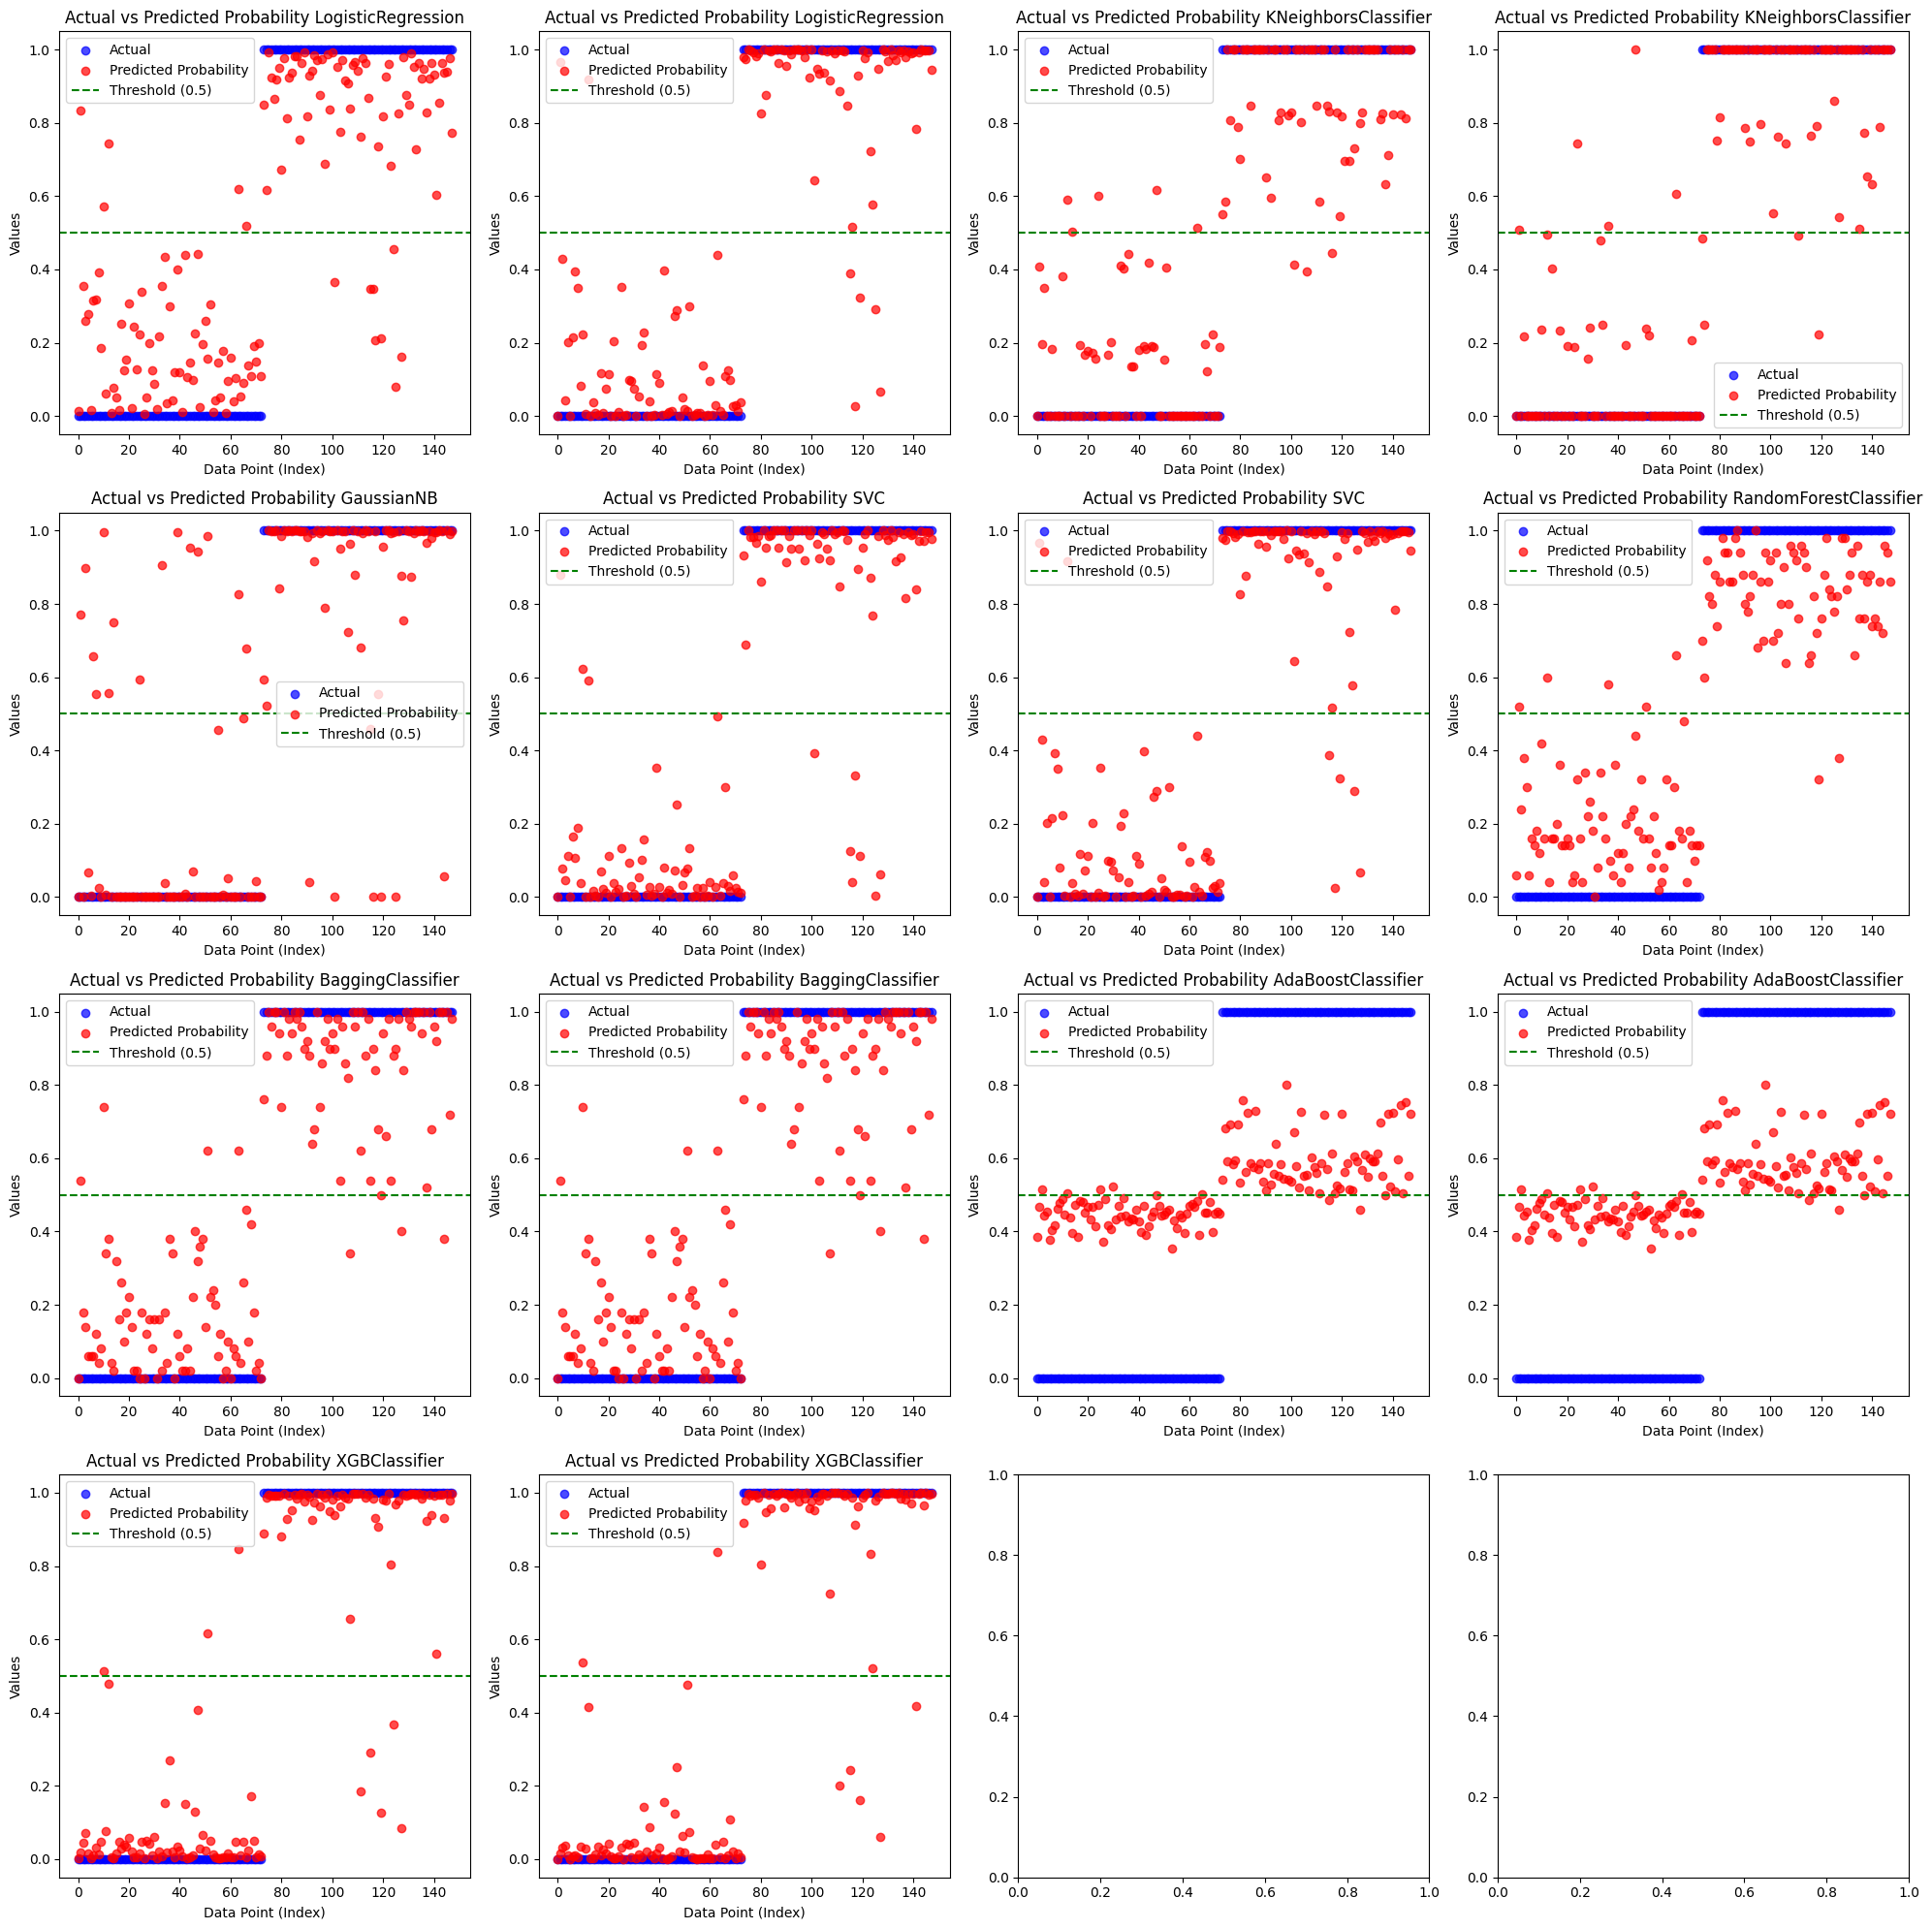

In [77]:

def PVASubplot(comparison_df, ax):
    # Sort the DataFrame by the 'Actual' column
    model_name = comparison_df.Name
    sorted_df = comparison_df.sort_values(by='Actual')

    # Scatter plot of Actual vs Predicted Probability
    ax.scatter(range(len(sorted_df)), sorted_df['Actual'], label='Actual', color='blue', alpha=0.7)
    ax.scatter(range(len(sorted_df)), sorted_df['Predicted_Probability'], label='Predicted Probability', color='red', alpha=0.7)

    # Draw a horizontal line at y=0.5
    ax.axhline(y=0.5, color='green', linestyle='--', label='Threshold (0.5)')

    ax.set_xlabel('Data Point (Index)')
    ax.set_ylabel('Values')
    ax.set_title('Actual vs Predicted Probability ' + model_name)
    ax.legend()


all_models_df = [table_lr, table_lr_2, table_knn, table_knn_2, table_nb, table_svm, table_svm_2, table_rf, table_bgcl, table_bgcl_2, table_adabc, table_adabc_2, table_xgbc, table_xgbc_2]

rows = 4
cols = 4

# Create a subplot grid
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 20))

for i in range(len(all_models_df)):
    PVASubplot(all_models_df[i], axes[i//cols][i%rows])

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


<b>IGNORE - (only for copy and paste purposes)</b>

In [78]:
blankIndex=[''] * len(final_results_df)
final_results_df.index=blankIndex
display(final_results_df)

,accuracy,precision,recall,f1-score
,0.91,0.91,0.91,0.91
,0.95,0.95,0.95,0.95
,0.95,0.95,0.95,0.95
,0.94,0.94,0.94,0.94
,0.85,0.86,0.85,0.85
,0.93,0.93,0.93,0.93
,0.97,0.97,0.97,0.97
,0.95,0.95,0.95,0.95
,0.95,0.95,0.95,0.95
,0.95,0.95,0.95,0.95
